# Learn about Obi-Wan Kenobi

Are you a star wars fan? If not, this exercise will help you learn about one of the most important character of the saga: Obi-Wan Kenobi. We will scrap a wikipedia page and create a word cloud to understand what comes out of the article. 

* To focus on NLP, let's use the following code to retrieve a clean HTML page from a variable. We will see later in the program how it works: 

```
import requests
from bs4 import BeautifulSoup
r = requests.get( "https://fr.wikipedia.org/wiki/Obi-Wan_Kenobi" )
html_doc = r.text
soup = BeautifulSoup(html_doc, 'html.parser')

corpus = [ ]
for p in soup.find_all("p"):
  corpus.append(p.text)
```

In [165]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import pandas as pd


r = requests.get( "https://fr.wikipedia.org/wiki/Obi-Wan_Kenobi" )
html_doc = r.text
soup = BeautifulSoup(html_doc, 'html.parser')

corpus = [ ]
for p in soup.find_all("p"):
  corpus.append(p.text)
corpus[0]

'\n\t\tPages pour les contributeurs déconnectés en savoir plus\n'

* We need to install `spacy` modules corresponding to the language specifics (in this case French). So install `en_core_news_sm`. 
  * Feel free to help you with documentation: [English](https://spacy.io/models/fr)

In [11]:
# !python -m spacy download fr_core_news_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


* Since text is in french, import now `fr_core_news_sm` --> [Documentation](https://spacy.io/models)

In [155]:
import fr_core_news_sm
nlp = fr_core_news_sm.load()

* For the rest, we need to create a complete corpus of text in a variable. This is a best-practice in the use of spacy. So you will need to create a clean corpus of text. You can do this with the help of : 
  * join()
  * strip() 
  
* Make some basic cleanings :
  * remove special characters
  * make sure there are no uppercase

In [196]:
import re
corpus2 = corpus

for i in range(len(corpus2)):
    corpus2[i] = corpus2[i].strip()
    corpus2[i] = corpus2[i].replace("\xa0", "")
    corpus2[i] = re.sub(r'\[.*?\]', '', corpus2[i])

corpus2 = ''.join(corpus2)
corpus2 = corpus2.lower()
corpus2 = re.sub(r"[!\"#$%&()*+,-./:;<=>?@[\\\]^_`{|}~]+", "", corpus2)
print (corpus2[0:101] + " ...")


pages pour les contributeurs déconnectés en savoir pluspour les articles homonymes voir obiwan kenobi ...


* Now load your clean corpus in a `doc` object.

In [197]:
doc = nlp(corpus2)

* With the `wordcloud` library, create a first word cloud 

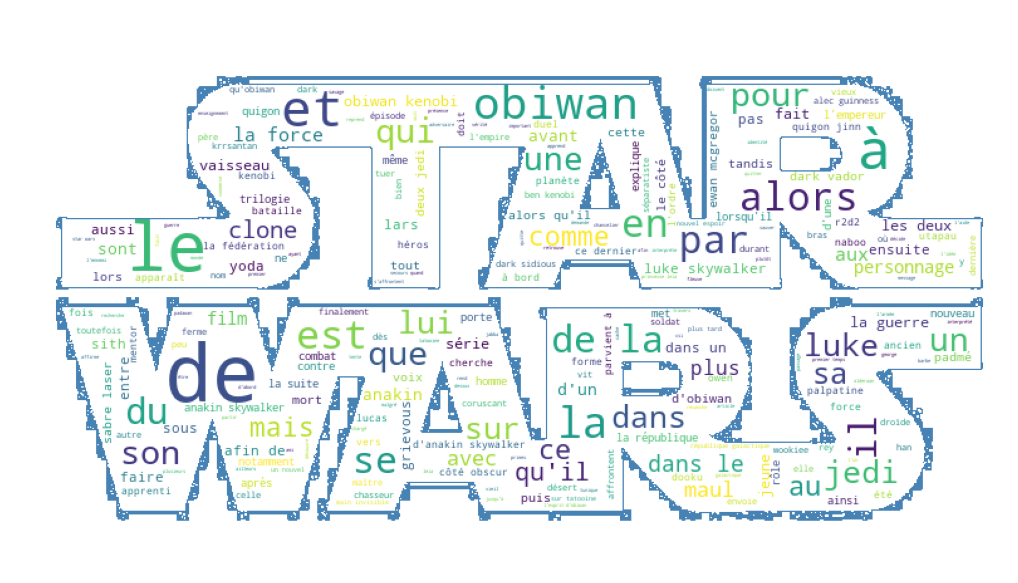

In [198]:
from PIL import Image



mask = np.array(Image.open("starwars_logo.jpg"))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0],
               contour_color='steelblue', contour_width=1)
wc.generate(corpus2)

plt.figure(figsize=(18, 11))
plt.imshow(wc)
plt.axis("off")
plt.show()

* Now import the stop-words present in `spacy`

In [199]:
from spacy.lang.fr.stop_words import STOP_WORDS

for i in range (10):
    print(list(STOP_WORDS)[i])

devant
donc
tenant
celles-là
bat
anterieur
merci
concernant
seize
toutes


* Make a word cloud again without the stop words

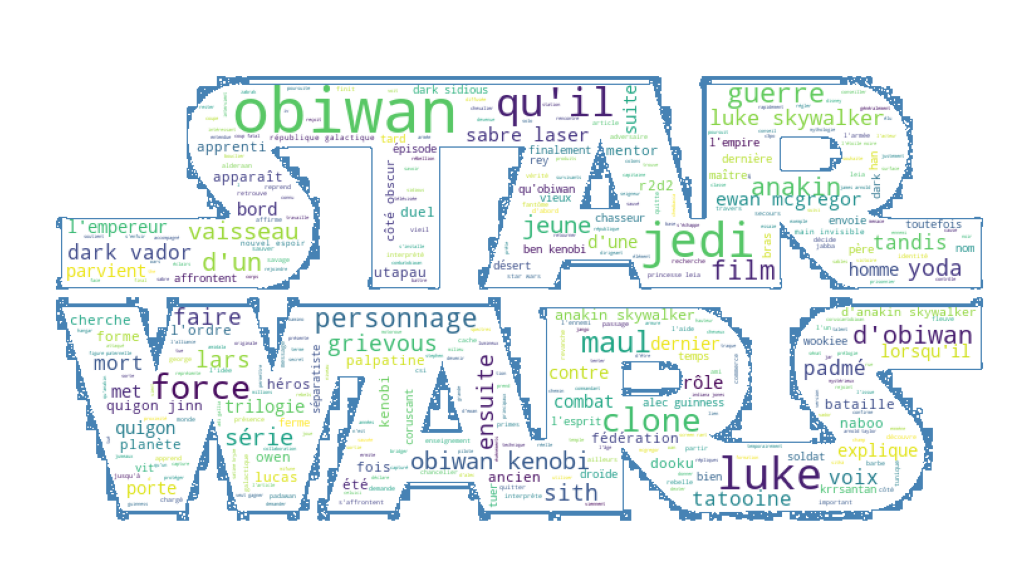

In [200]:
from spacy.lang.fr.stop_words import STOP_WORDS
stopwords2 = set(STOP_WORDS)

wc = WordCloud(mask=mask, stopwords=stopwords2, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0],
               contour_color='steelblue', contour_width=1)
wc.generate(corpus2)

plt.figure(figsize=(18, 11))
plt.imshow(wc)
plt.axis("off")
plt.show()

* We would need to have a corpus of lemmatized words, recreate a corpus of lemmatized words and visualize your new word cloud

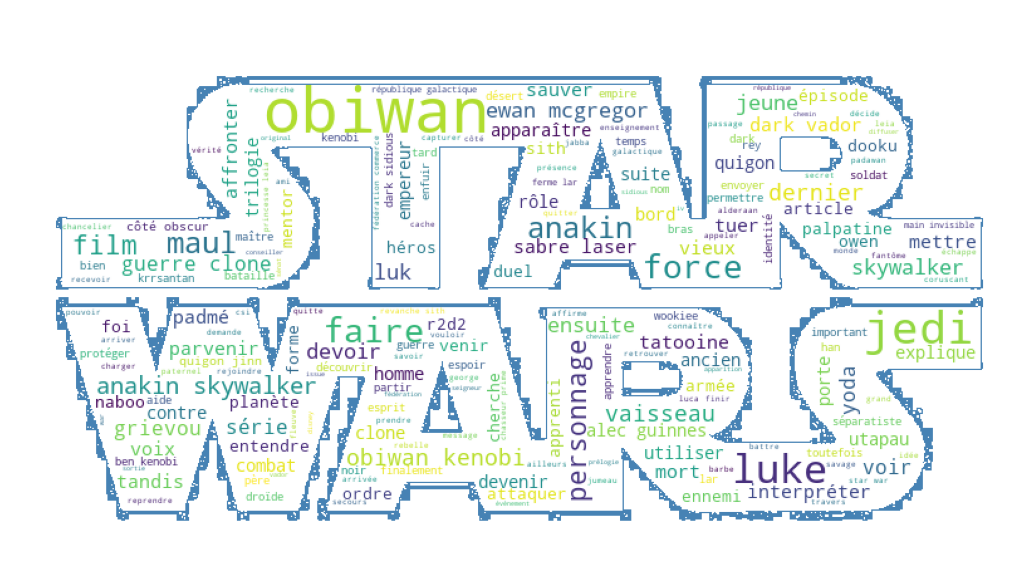

In [201]:
corpus3 = [token.lemma_ for token in doc]
corpus3 = [word for word in corpus3 if word not in stopwords2]
corpus4 = ' '.join(corpus3)

wc = WordCloud(mask=mask, background_color="white", 
                max_font_size=256,
               contour_color='steelblue', contour_width=1)
wc.generate(corpus4)

plt.figure(figsize=(18, 11))
plt.imshow(wc)
plt.axis("off")
plt.show()


* Let's push analysis further! Some words are really common in our corpus, find which of them

In [202]:
# Create a DataFrame of lemmatized token
lemmadf = pd.Series(corpus3)

# Create a mask of all counted values greater than 22
common = lemmadf.value_counts()>15

# Apply mask
common = common[common]

#Visualize first ten terms 
common[:10]

obiwan       True
jedi         True
luke         True
anakin       True
skywalker    True
faire        True
kenobi       True
force        True
dtype: bool

* Update your list of stop words with the common words

In [203]:
# Update stop words 
new_stop_words = common.index

# Create a union of sets 
STOP_WORDS_updated = STOP_WORDS.union(new_stop_words)

* Create a new word cloud 

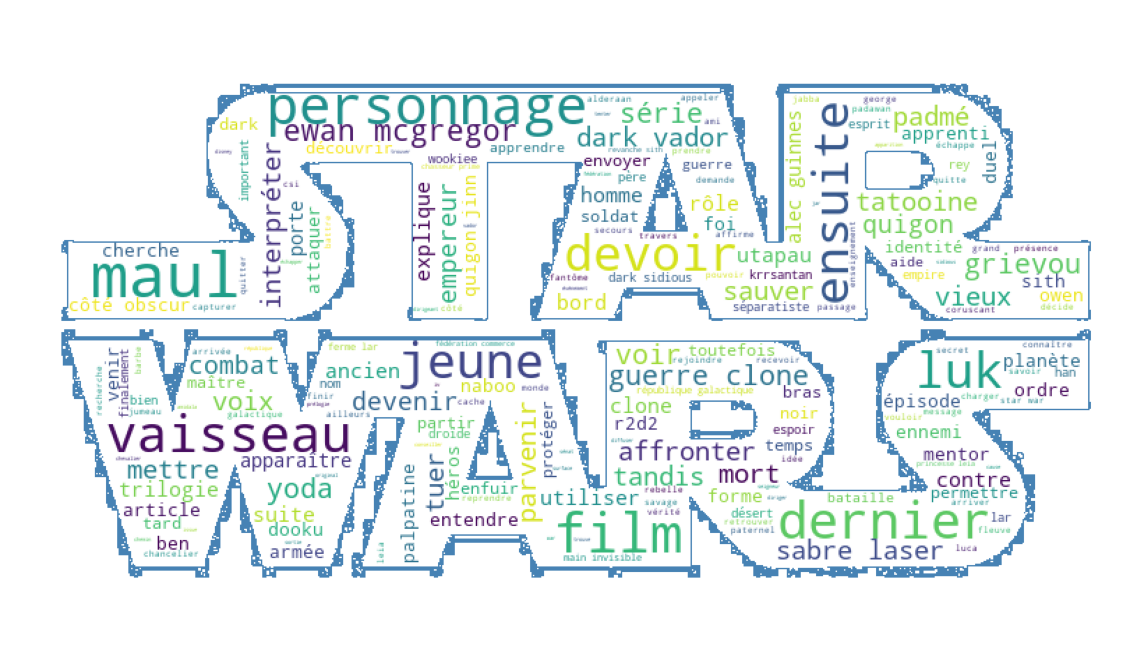

In [207]:
import wordcloud
# Create a word cloud 
wd = wordcloud.WordCloud(background_color="white", contour_width=1, contour_color='steelblue', mask = mask, 
               stopwords=STOP_WORDS_updated)

# Generate wordcloud
cloud = wd.generate(corpus4)

# Visualize wordcloud 
plt.figure(figsize = (20, 20))
plt.imshow(cloud)
plt.axis("off")
plt.show()

* We will now start building a tf-idf matrix. Let's first create a DataFrame containing our lemmatized corpus without the updated stop words.

In [208]:
# Create lemmatization 
lemma = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS_updated]

# Create a new corpus 
corpus_lemma = " ".join(lemma)

# Create a Series with 1 document
corpus_series = pd.Series(corpus_lemma)

# Include Series in a DataFrame for simpler manipulations 
corpus_df = pd.DataFrame(corpus_series, columns=["documents"])
corpus_df

,documents
0,page contributeur déconnecter savoir pluspour ...


* Let's create now a TF-IDF matrix using `sklearn`

In [209]:
# Tfidf transformer 
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus_df['documents'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0.01199261, 0.01199261, 0.01199261, ..., 0.01199261, 0.02398523,
        0.02398523]])

* Visualize most important words using `seaborn`, `matplotlib` or `plotly`

> Help: You can create a dataframe, transpose it and then easily create a visualization

In [210]:
# Creating a DataFrame with all the words and tf-idf score 
tfid_df = pd.DataFrame(dense, 
                        columns=[x for x in vectorizer.get_feature_names()])

tfid_df

C:\Users\Berenger\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,136,179,182,19ans,2000,2000le,2004,2014,2016,2019,...,émission,épique,épisode,épreuve,équilibre,étoile,étouffe,évade,évènement,œuvre
0,0.011993,0.011993,0.011993,0.011993,0.011993,0.011993,0.011993,0.011993,0.011993,0.011993,...,0.023985,0.011993,0.059963,0.011993,0.011993,0.023985,0.011993,0.011993,0.023985,0.023985


In [211]:
# Transpose dataframe
tfid_df = tfid_df.T

# Create a new token column 
tfid_df["token"] = tfid_df.index

tfid_df

,0,token
136,0.011993,136
179,0.011993,179
182,0.011993,182
19ans,0.011993,19ans
2000,0.011993,2000
...,...,...
étoile,0.023985,étoile
étouffe,0.011993,étouffe
évade,0.011993,évade
évènement,0.023985,évènement


In [212]:
# Sort the top 15 values by descending order
tfid_df.sort_values(by=0, ascending=False)[:15]

,0,token
dark,0.179889,dark
clone,0.167897,clone
maul,0.167897,maul
guerre,0.143911,guerre
quigon,0.131919,quigon
film,0.131919,film
personnage,0.131919,personnage
vaisseau,0.119926,vaisseau
dernier,0.119926,dernier
ensuite,0.107934,ensuite


In [213]:
# Import plotly express
import plotly.express as px

# Create bar chart
fig = px.bar(tfid_df.sort_values(by=0, ascending=False)[:15], x="token", y=0)

# Render chart
fig.show()